# NLP Project: Document Classification by Inversion of Distributed Language Representations (Part 3)

In a **Word2Vec model** such as the Skip-Gram model, each **word** is mapped into a **vector-space** that is rich in **structure and information**. 

In this paper *[Document Classification by Inversion of Distributed Language Representations](http://arxiv.org/pdf/1504.07295v3.pdf)* (24 July 2015), it is demonstrated how a distributed language representation can be turned into a classifier through inversion
via **Bayes Rule**.

## Bayesian Inversion
It is a simple model that turns fitted **distributed language
representations** into **document classifiers**.

$$P(Category|Review) = \frac{P(Review|Category)P(Category)}{P(Review)}$$

The idea is to train **separate distributed language representations** (Word2Vec) for **each set of document categories**.
Therefore we train a **word vector** ($V_c$) once for each corpus category. With these different language representations **Bayes Rule** can then be applied.

$$P(y|Review) = \frac{P_{v_c}(Review|y)\pi_y}{\Sigma_cP_{v_c}(Review|Category)\pi_c}$$

First the Skip-gram likelihood need to be computed for each word. Given a **context word** and the input and output **weight matrices**, we can compute a **score** for each word in the vocabulary. This is essentially a **multiclass classification** where we have as many labels as our vocabulary size $V$. **Softmax regression**, a log-linear classification model, is used to compute the **posterior probability $P(Word_s|Sentence)$:**

$$ P(Word|Sentence) = y_i = \frac{exp(W_I \cdot W'^T_O)}{\sum^V_{j=1} exp(W_I \cdot W'^T_j)} $$

The posterior is **re-computed for each language model**.

The **likelihood of the review** is simply the **average likehood of every word** (again for each language model).

$$P_{v_c}(Review|Category) = \frac{1}{S}\sum_sP_{v_c}(Word_s|Sentence)$$

Finally the class prediction is the **maximum likelihood**.

$$\hat{y} = argmax(P_{v_c}(Review|Category))$$

In [58]:
from numpy import average
import os
import gensim
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#sns.set_style(style='white')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

import graphlab as gl
gl.canvas.set_target('ipynb')
#gl.canvas.set_target('browser')

# Reuse Constructed Modules From Word2Vec

In [7]:
from NLPutils import *
"""
The NLPutils file makes available the following functions and classes.

Func: 
    * load_json_from_file()
    * txt2sentences()
    * txt2words()
    * print_statistics()

Class:
    * TrainSentences
    * DeepTextAnalyzer
""";

# Load New Review Category

In [8]:
Health = load_json_from_file('/Users/marvinbertin/Desktop/data/reviews_Health_and_Personal_Care.json')

PROGRESS: Finished parsing file /Users/marvinbertin/Desktop/data/reviews_Health_and_Personal_Care.json
PROGRESS: Parsing completed. Parsed 100 lines in 0.751988 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Read 86192 lines. Lines per second: 53562.5
PROGRESS: Read 521499 lines. Lines per second: 77342.3
PROGRESS: Read 958860 lines. Lines per second: 77256.7
PROGRESS: Read 1394223 lines. Lines per second: 77967.6
PROGRESS: Read 1831981 lines. Lines per second: 77957
PROGRESS: Read 2280766 lines. Lines per second: 78767.6
PROGRESS: Read 2734630 lines. Lines per second: 79659.5
PROGRESS: Finished parsing file /Users/marvinbertin/Desktop/data/reviews_Health_and_Personal_Care.json
PROGRESS: Parsing comp

# Visualize Data

In [9]:
Health.show()

# Proprocess, Parse & Train in One Go!

In [10]:
def train_Word2Vec(sf, name):
    """
    Preprocess and parse reviews
    Train a Word2Vec model on reviews
    :param sf: SFrame of reviews
    :param name: document category
    """
    BASE_DIR = "/Users/marvinbertin/Desktop/data"
    
    # remove empty reviews
    sf = sf.filter_by(values = '',
                      column_name = 'reviewText',
                      exclude = True)
    # shuffle reviews
    sf_shuffled = gl.toolkits.cross_validation.shuffle(sf)
    
    # train on the same number of reviews as in the Sport word2vec model
    sf_train = sf_shuffled[:750000] 
    
    # store out-of-bag reviews for the test set
    sf_test = sf_shuffled[-10000:]
    
    
    # Combine all the Reviews into one file
    mashed_train = "\n".join(sf_train['reviewText'])
    filename_train = name + "TrainReviews.txt"
    with open(os.path.join(BASE_DIR, "txt" , filename_train), "w") as f:
        f.write(mashed_train)
        
    # Repeat for test data
#     mashed_test = "\n".join(sf_test['reviewText'])
#     filename_test = name + "TestReviews.txt"
#     with open(os.path.join(BASE_DIR, "txt" , filename_test), "w") as f:
#         f.write(mashed_test)
    
    # Preprocess and Extract sentences from train txt file
    sentences = TrainSentences(os.path.join(BASE_DIR, "txt", filename_train))

    # Train word2vec model
    model = gensim.models.Word2Vec(sentences,
                                   size=300,
                                   min_count=40,
                                   window=8)
    
    # save model
    modelName = name + "_300_c_40_w_8.word2vec"
    model.save(os.path.join(BASE_DIR , modelName))
    
    return sf_test

# Train a Different Word2Vec Model for each Category

In [11]:
Health_test = train_Word2Vec(Health, name = "health")

In [ ]:
Toys_test = train_Word2Vec(Toys, name = "toys")

In [ ]:
Sport_test = train_Word2Vec(Sport, name = "sport")

## Load Language Models

In [12]:
modelSport = gensim.models.Word2Vec.load("/Users/marvinbertin/Desktop/data/sport_300_c_40_w_8.word2vec")

In [13]:
modelToys = gensim.models.Word2Vec.load("/Users/marvinbertin/Desktop/data/toys_300_c_40_w_8.word2vec")

In [14]:
modelHealth = gensim.models.Word2Vec.load("/Users/marvinbertin/Desktop/data/health_300_c_40_w_8.word2vec")

# Sentence Parser for Test Data
** removes white spaces, stop words, non-english words **

In [16]:
def sentenceParser(txt):
    # separate txt into sentences
    for sent in txt2sentences(txt):
        
        # split the sentence into words using regex
        w =txt2words(sent,
                     lower=True,
                     remove_stop_words=True,
                     remove_none_english_chars=True)
        yield w

# My Implementation of Bayesian Inversion

In [77]:
def categoryProbability(reviews, model_list, categories):
    
    # list of reviews that contain a list of sentences
    docs = [list(sentenceParser(r)) for r in reviews]
    
    # list all sentences in all reviews
    sent_list = [s for d in docs for s in d]
    
    # log likelihood of each sentence in this review for each w2v model representation
    log_likelihood = np.array([ m.score(sent_list, len(sent_list)) for m in model_list ])
    
    # Likelihoods for each model
    # avoid numeric overload by subtracting row max, range(0,1)
    likelihood = np.exp(log_likelihood - log_likelihood.max(axis=0))
    
    # normalize across models to get P(sentence| category)
    prob = gl.SFrame( (likelihood/likelihood.sum(axis=0)).T )
    
    # and finally average the sentence probabilities to get the review probability
    prob["reviewID"] = [i for i,d in enumerate(docs) for s in d]
    
    # group sentences by review and compute the mean probability
    sf = prob.groupby('reviewID', operations = {'probabilities': gl.aggregate.MEAN('X1')})
    
    # append prob for each category
    for i, cat in enumerate(categories):
        sf[cat] = sf['probabilities'].apply(lambda x: x[i])
    
    # make class prediction based on max probability
    sf['prediction'] = sf['probabilities'].apply(lambda p: categories[np.argmax(p)])
    return sf

# Reviews are lengthy and can be very general (noisy)
**My yoga mat is too slippery! (1st world problem)**

In [81]:
Sport_test['reviewText'][3]

'Such a let down! I tried to use this mat last night for the first time at yoga class. Within the first pose, my hands and feet were slipping! I had wiped my hands off multiple times and was still slipping. I never had this problem with my cheap mat from Target. The instructor then let me use his thick black rubber mat, and I immediately had no problems with slipping.'

In [85]:
# No mention of the product
Sport_test['reviewText'][4000]

'It was nice, but I was allergic to something in the material. It was not compatible with my physiology. Thanks anyway.'

# Run Document Classifier on Sport Reviews

In [78]:
model_list = [modelSport, modelToys, modelHealth]
categories = ['Sport', 'Toys', 'Health']

In [79]:
Sport_predictions = categoryProbability(Sport_test['reviewText'][:1000], model_list, categories)
Sport_predictions 

reviewID,probabilities,Sport,Toys,Health,prediction
118,"[0.650735631585,0.0933020189714, ...",0.650735631585,0.0933020189714,0.255962342024,Sport
435,"[0.73966645201,0.0385487142603, ...",0.73966645201,0.0385487142603,0.221784856688,Sport
537,"[1.0, 2.67529850054e-25,0.0] ...",1.0,2.67529850054e-25,0.0,Sport
526,"[0.107842810452,0.372182071209, ...",0.107842810452,0.372182071209,0.519975109026,Health
232,"[0.872195065022,0.0207413057132, ...",0.872195065022,0.0207413057132,0.107063651109,Sport
310,"[0.790092806021,7.8839134081e-05, ...",0.790092806021,7.8839134081e-05,0.209828350693,Sport
49,"[0.898297131062,0.0759401898833, ...",0.898297131062,0.0759401898833,0.0257626434659,Sport
13,"[0.999884128571,5.46913452822e-05, ...",0.999884128571,5.46913452822e-05,6.11983346614e-05,Sport
511,"[1.0, 2.93714840867e-33,6.25126513455e-25] ...",1.0,2.93714840867e-33,6.25126513455e-25,Sport
363,"[0.4834624129,0.317046792647, ...",0.4834624129,0.317046792647,0.19949075114,Sport


# Evaluation

In [70]:
print "RECALL for Sport Reviews: ", (Sport_predictions['prediction'] == 'Sport').mean()

RECALL for Sport Reviews:  0.686686686687


** Recall is decent, but let's visualize the distribution**

## Visualize Posterior Probability Distributions

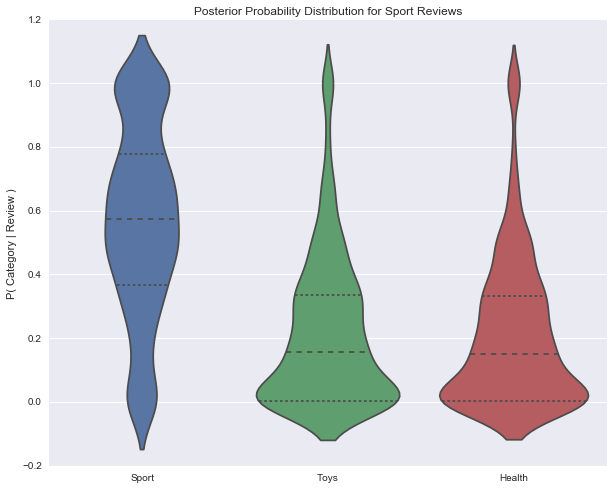

In [71]:
sns.violinplot(data =Sport_predictions[['Sport', 'Toys', 'Health']].to_dataframe(), inner="quartile")
plt.title("Posterior Probability Distribution for Sport Reviews")
plt.ylabel("P( Category | Review )");

**What to note**:
* The large majority of reviews have a very low probability of being in class *Toys* and *Health*
* Some are misclassified probably because of ambiguous review such as the ones we saw above (no mention of product and very chatty)
* Overall the classifier did pretty well at segmenting the reviews
* Interestingly the *Sport* distribution has high variance. It seems like there are multiple distributions of different review clusters
* The Sport category is very broad (from yoga to skydiving), and it manifestation itself in the distribution. 

# Document Classifier on Toys Reviews

In [80]:
Toys_predictions = categoryProbability(Toys_test['reviewText'][:1000], model_list, categories)
Toys_predictions 

reviewID,probabilities,Sport,Toys,Health,prediction
118,"[0.56354202951,0.406135767698, ...",0.56354202951,0.406135767698,0.0303221835726,Sport
435,"[0.429196876939,0.427886835166, ...",0.429196876939,0.427886835166,0.142916295579,Sport
537,"[0.453824656562,0.20594552557, ...",0.453824656562,0.20594552557,0.34022981244,Sport
526,"[5.13829560514e-21, 1.0,1.18627375692e-22] ...",5.13829560514e-21,1.0,1.18627375692e-22,Toys
232,"[0.00149945270414,0.99742213885, ...",0.00149945270414,0.99742213885,0.00107844662854,Toys
310,"[0.0, 1.0, 0.0]",0.0,1.0,0.0,Toys
49,"[0.237961930118,0.510109938989, ...",0.237961930118,0.510109938989,0.251928119629,Toys
13,"[0.333333333333,0.666666666667, ...",0.333333333333,0.666666666667,8.47129156006e-38,Toys
511,"[7.19847021124e-42, 1.0,4.73470725126e-41] ...",7.19847021124e-42,1.0,4.73470725126e-41,Toys
363,"[0.333333343267,0.333333343267, ...",0.333333343267,0.333333343267,0.333333343267,Sport


********************************************************************************
RECALL for Toys Reviews:  0.739959839357


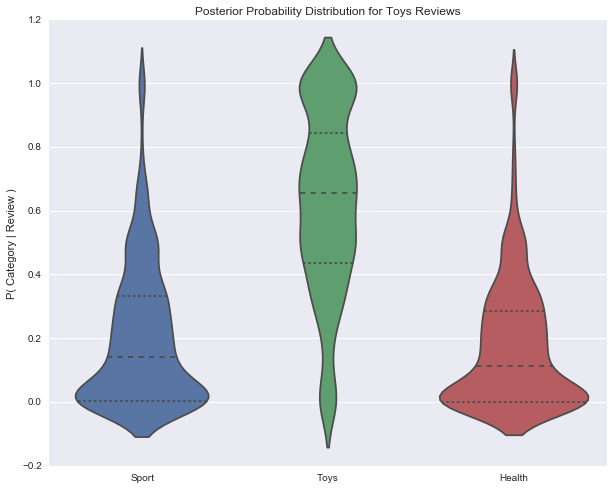

In [74]:
print "*"*80
print "RECALL for Toys Reviews: ", (Toys_predictions ['prediction'] == 'Toys').mean()

sns.violinplot(data =Toys_predictions [['Sport', 'Toys', 'Health']].to_dataframe(), inner="quartile")
plt.title("Posterior Probability Distribution for Toys Reviews")
plt.ylabel("P( Category | Review )");

**What to note:**
* That Toy Classifier performed even better than the Sports one.
* The median probability of the *Toys* is clearly above the other two
* The target distribution has also a large variance, but the separation is even more distinct.

# Document Classifier on Health Reviews

********************************************************************************
RECALL for Health Reviews:  0.56


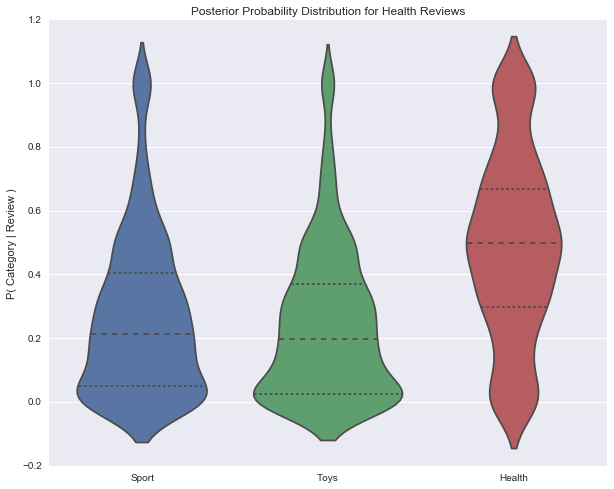

In [75]:
# predict
Health_predictions = categoryProbability(Health_test['reviewText'][:1000], model_list, categories)

# Recall
print "*"*80
print "RECALL for Health Reviews: ", (Health_predictions['prediction'] == 'Health').mean()

# Plot
sns.violinplot(data =Health_predictions[['Sport', 'Toys', 'Health']].to_dataframe(), inner="quartile")
plt.title("Posterior Probability Distribution for Health Reviews")
plt.ylabel("P( Category | Review )");

** What to note:**
* Health review is a tough one, the classifier didn't perform as well.
* Health is the most general category (books, supplements, clothes). Most reviews are more like stories than specific description of a product.

** Conlusion**
Bayesian Inversion for document classsification is a simple model that works suprisingly well at classifying product review into their original categories.

** 3 advantages of Bayesian Inversion:**

1. *Simplicity*: The inversion strategy works for any model of language that can be interpreted as a probabilistic model

2. *Scalability*: Splitting and training the corpora into different models, makes it easier to work with large dataset. Additionally, this makes distributed computing much simplier.

3. *Performance*: The model can actually outperform, at times, some of the more complext state-of-the art models, such as Doc2Vec-based classification and the multinomial inverse regression (Taddy, 2013b).